# Probabilistic Machine Learning
#### Machine Learning in Science, University of Tübingen, Summer Semester 2024
## Exercise 11

Authors: Janne Lappalainen, Jaivardhan Kapoor

**hand in before 11.07.2022, 08:00 a.m.**

---
In the lecture you learned about normalizing flows, a series of bijective transformations on random variables to learn probability densities. In this programming exercise, you will explore how to build and train normalizing flows in `Pytorch`. For this assigmnent, you will use `Pyro`, a popular (and powerful) probabilistic programming library based on `Pytorch`.

## Outline
1) Creating composable and invertible transformations in `Pyro`.

2) Approximating complex univariate distributions using learnable bijections in `Pyro`.

3) Approximating multivariate distributions using normalizing flows -- analysing the importance of coupling flows as opposed to merely learning marginals. 

### References:

[1] Kevin P Murphy. "Probabilistic Machine Learning: Advanced Topics". Chapter 23. https://probml.github.io/pml-book/book2.html

[2] https://pyro.ai/examples/normalizing_flows_i.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.distributions import beta

np.random.seed(42)

import torch
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
smoke_test = ('CI' in os.environ)

# to ignore seaborn deprecation warnings
import warnings
warnings.filterwarnings("ignore")


# importing pyro modules 
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [2]:
# !conda install seaborn -c conda-forge -y
# !pip install pyro-ppl 

# Normalizing flows
## Convert a simple probability distribution to a complex probability distribution

Consider a random variable $\mathbf{u} \in \mathbb{R}^d$ from a simple base distribution $p_{\mathbf{u}}(\mathbf{u})$, e.g. standard normal -- so that we can sample it easily, $\mathbf{u} \sim \mathcal{N}(0, \mathbb{1})$. A normalizing flow is a bijective (in fact diffeomorphic, i.e. bijective and differentiable) transformation that transforms $\mathbf{u}$ into  $\mathbf{x}$ with a more complex distribution over it.

$$\mathbf{x} = f(\mathbf{u}) \qquad \text{with }\,\mathbf{x} \in \mathbb{R}^d,\,\mathbf{u} \sim p_{\mathbf{u}}(\mathbf{u})\text{.}$$

To sample from the distribution over $\mathbf{x}$, denoted by $p_\mathbf{x}(\mathbf{x})$, we simply sample from $p_{\mathbf{u}}(\mathbf{u})$ and then compute $\mathbf{x}=f(\mathbf{u})$.
Because $f$ is bijective, we can compute the density $p(\mathbf{x})$ using the change-of-variables formula for random variables and the inverse function theorem for Jacobian matrices:

$$p_\mathbf{x}(\mathbf{x}) = p_\mathbf{u}(f^{-1}(\mathbf{x}))|\text{det}\,\mathbf{J}_{f^{-1}}(\mathbf{y})| = p_\mathbf{u}(\mathbf{u})|\text{det}\,\mathbf{J}_f(\mathbf{u})|^{-1}\text{.}$$

$\mathbf{J}_f$ with $J_{f,ij} = \frac{\partial f_i}{\partial \mathbf{u}_j}$ is the Jacobian of $f$ evaluated at $\mathbf{u}$. We can take the logarithm of the above equation:

$$\log p_\mathbf{x}(\mathbf{x}) = \log p_\mathbf{u}(\mathbf{u}) - \log|\text{det}\,\mathbf{J}_f(\mathbf{u})|$$

to gain an intuitive understanding: the density of $\mathbf{x}$ is equal to the density at the corresponding point $\mathbf{u}$ up to a term that corrects for the _warp_ in the volume caused by $f$.

Furthermore, we can compose bijective transformations to produce even more expressive transformations. With $N$ transformations $f_1, \ldots, f_N$, the initial random vector gets transformed by composing these transformations:

\begin{align*}
\mathbf{x}^{(0)} &= \mathbf{u}\\
\mathbf{x}^{(1)} &= f_1(\mathbf{x}^{(0)})\\
& \vdots \\
\mathbf{x} = \mathbf{x}^{(N)} &= f_N(\mathbf{x}^{(N-1)})\\
\end{align*}

the density of the final transformation can be written as

$$\log p_\mathbf{x}(\mathbf{x}) = \log p_\mathbf{u}( (f_n\circ ...\circ f_1)^{-1} (\mathbf{x})) - \sum_{n=1}^N\log|\text{det}\,\mathbf{J}_{f_i}(\mathbf{x}^{(i-1)})|,$$

as the composition of invertible functions is also invertible, with the resulting Jacobian being the product of the Jacobians of all transformations. The transformation $f_n\circ ...\circ f_1$ desribes a succesive warp of the volume in the space of $\mathbf{u}$. Such a family of diffeomorpishms is called "flow" in mathematics -- with the base density $\log p_\mathbf{u}$ usually being a normal distribution, the term _normalizing flows_ was coined. 

## Implementing a composition of simple invertible transformations in Pyro

For this programming exercise, please keep the `Pyro` [documentation](https://docs.pyro.ai/en/stable/) open and refer to respective sections for transformations, distributions, learning methods etc.

1. The [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) is a continuous probability distribution frequenty used in sciences and economics. The logarithm of a log-normally distributed variable $x$ is normally distributed, that is, $\log(x)\sim \mathcal{N}(\mu, \sigma^2)$.\
\
Your task is to generate samples of a log-normally distributed random variable. Starting from a normally-distributed variable, compose _affine_ and _non-linear_ transformations to create a log-normal distribution with $\mu=3, \sigma=0.5$. Plot samples and [KDE plot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) for both the original normal distribution and the lognormal distribution.\
\
Use `pyro.distributions` and `pyro.distributions.transforms` in your implementation.

In [13]:
# Create a distribution by composing transforms and applying them to a base distribution
mu = torch.ones(1) * 3
sigma = torch.ones(1) * 0.5
dist_u = dist.Normal(loc=mu, scale=sigma)
dist_x = dist.TransformedDistribution(dist_u,
                                      [T.ExpTransform()])

In [14]:
# dist_u.sample(sample_shape=(100, ))
# T.ExpTransform(dist_u)

In [15]:
n_samples = 1000
samples_u = dist_u.sample(sample_shape=(n_samples, ))
samples_x = dist_x.sample(sample_shape=(n_samples, ))

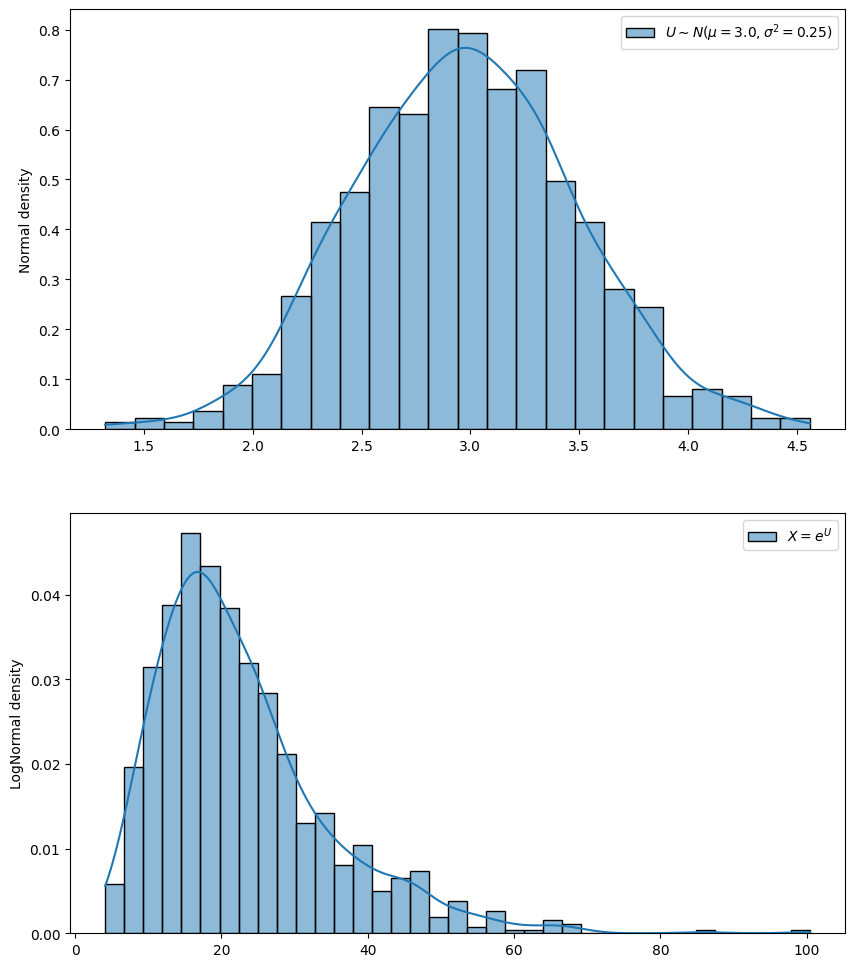

In [25]:
# Plot the KDE plot of the base distribution and transformed distribution here.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10*1, 6*2))
sns.histplot(samples_u, kde=True, stat='density', label=rf'$U \sim N(\mu={mu.item()}, \sigma^2={sigma.item()**2})$', ax=axes[0])
sns.histplot(samples_x, kde=True, stat='density', label=r'$X = e^U$', ax=axes[1])
axes[0].set_ylabel('Normal density')
axes[1].set_ylabel('LogNormal density')
axes[0].legend(); axes[1].legend()
plt.show()

## Implementing learnable invertible transformations (with the Pytorch backend)

2. In this section you will create a learnable normalizing flow and infer its parameters, given a dataset. Then you will plot samples from the flow and compare with the dataset.

(a) Generate the dataset by sampling from the previous lognormal distribution with $\mu=3, \sigma=0.5$.

In [26]:
n_samples = 1000

In [29]:
# Generate dataset from previously created lognormal distribution object
data = dist_x.sample_n(n_samples)
data.shape

torch.Size([1000, 1])

[Neural Spline Flows](https://arxiv.org/abs/1906.04032) are a highly flexible class of learnable bijective transformations. _Monotonic rational splines_ are flexible functions that are of the form 

\begin{align*}
s(u) = \begin{cases}
u & u \leq -B;\\
\frac{g_i(u)}{h_i(u)} & u \in [b_i, b_{i+1}]~\forall i \in \{1, \ldots, K\};\\
u & u \geq B;
 & \end{cases}
\end{align*}
The spline is made up of segments, with each segment represented by a rational function (**$g,h$ are both linear or quadratic in $u$**). At the knots $b_i$, i.e., the boundaries of the segments, a continuity constraint is placed on the values and derivatives:

\begin{align*}
\frac{g_{i-1}(b_{i})}{h_{i-1}(b_{i})} &= \frac{g_{i}(b_{i})}{h_{i}(b_{i})}, \text{and}\\
\frac{d}{du}\left(\frac{g_{i-1}(b_{i})}{h_{i-1}(b_{i})}\right) &= \frac{d}{du}\left(\frac{g_{i}(b_{i})}{h_{i}(b_{i})}\right)
\end{align*}


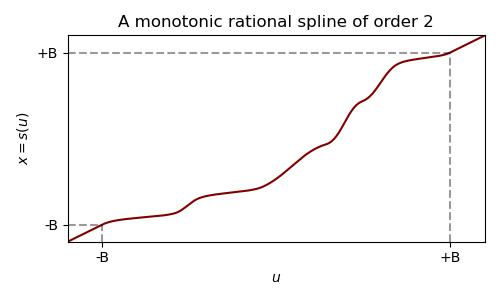

In [1]:
## Embedding the image in Jupyter cell, no need to rerun
# from IPython.display import Image
# Image(filename='spline.jpg')


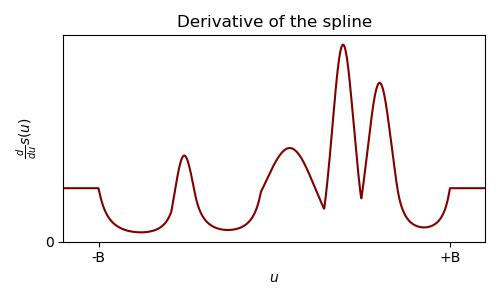

In [3]:
## Embedding the image in Jupyter cell, no need to rerun

# from IPython.display import Image
# Image(filename='splinedet.jpg')



Furthermore, the parameters of $g_i, h_i$ are also constructed in a way that the spline $s(u)$ is monotonically increasing in $u$, and $s(u) = u$ at $-B, B$. This makes $s(u)$ a flexible bijection -- by learning the parameters of $g_i$'s and $h_i$'s, $p_u(u)$ can be transformed into the desired $p_x(x)$.

<br><br>

(b) Scale the dataset you just created to zero mean and unit variance. Fit a learnable rational linear spline with 7 segments to the dataset. Use the loss based on Maximum Likelihood Estimation using the log-probability method of the [`Spline`](https://docs.pyro.ai/en/stable/distributions.html#pyro.distributions.transforms.Spline) object, and optimize it using `SGD`/`Adam` optimizer from [`Pyro.optim.pytorch_optimizers`](https://docs.pyro.ai/en/stable/optimization.html#pyro.optim.pytorch_optimizers).\
\
  After learning the paramters of the `Spline` object, generate new samples from it and compare the learned distribution with the original lognormal distribution. (Make sure to apply the inverse scaling you applied to the dataset in the first place for training.)\
\
  How does the learned distribution change as you increase the number of segments in the spline? 

In [103]:
# scale your data, so that it falls roughly into the domain/range of the Spline object

data_mean = data.mean()
data_std = data.std()
data_standardized = (data - data_mean) / data_std
data_standardized.mean(), data_standardized.std(), data_standardized.min(), data_standardized.max()

(tensor(2.7084e-07), tensor(1.), tensor(-1.5899), tensor(5.5928))

In [104]:
# Create your distribution with learnable transformation parameters

# create base distribution
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))

# create spline transform
# Tip: use the visualize_spline() function at the bottom of this notebook to develop intuition for the spline transformation.
spline_transform = T.Spline(1, count_bins=7, order='linear', bound=6)

# create transformed distribution
flow_dist = dist.TransformedDistribution(base_dist,
                                         [spline_transform])

In [105]:
flow_dist.log_prob(data_standardized).shape
# flow_dist.sample(sample_shape=(2, ))

torch.Size([1000, 1])

In [109]:
# Implement the training loop after initializing the optimizer and use the loss function provided by `log_prob` method of the TransformedDistribution object. Learn the parameters by optimizing the loss.
steps = 2_000
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-3)

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(data_standardized).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 1.2753846645355225
step: 100, loss: 1.2608253955841064
step: 200, loss: 1.2551032304763794
step: 300, loss: 1.2529304027557373
step: 400, loss: 1.2518559694290161
step: 500, loss: 1.2510895729064941
step: 600, loss: 1.2503995895385742
step: 700, loss: 1.2497526407241821
step: 800, loss: 1.2491604089736938
step: 900, loss: 1.2487032413482666
step: 1000, loss: 1.2483189105987549
step: 1100, loss: 1.2479795217514038
step: 1200, loss: 1.247610092163086
step: 1300, loss: 1.2473722696304321
step: 1400, loss: 1.2470835447311401
step: 1500, loss: 1.2469279766082764
step: 1600, loss: 1.246858835220337
step: 1700, loss: 1.2467041015625
step: 1800, loss: 1.2460497617721558
step: 1900, loss: 1.2457901239395142


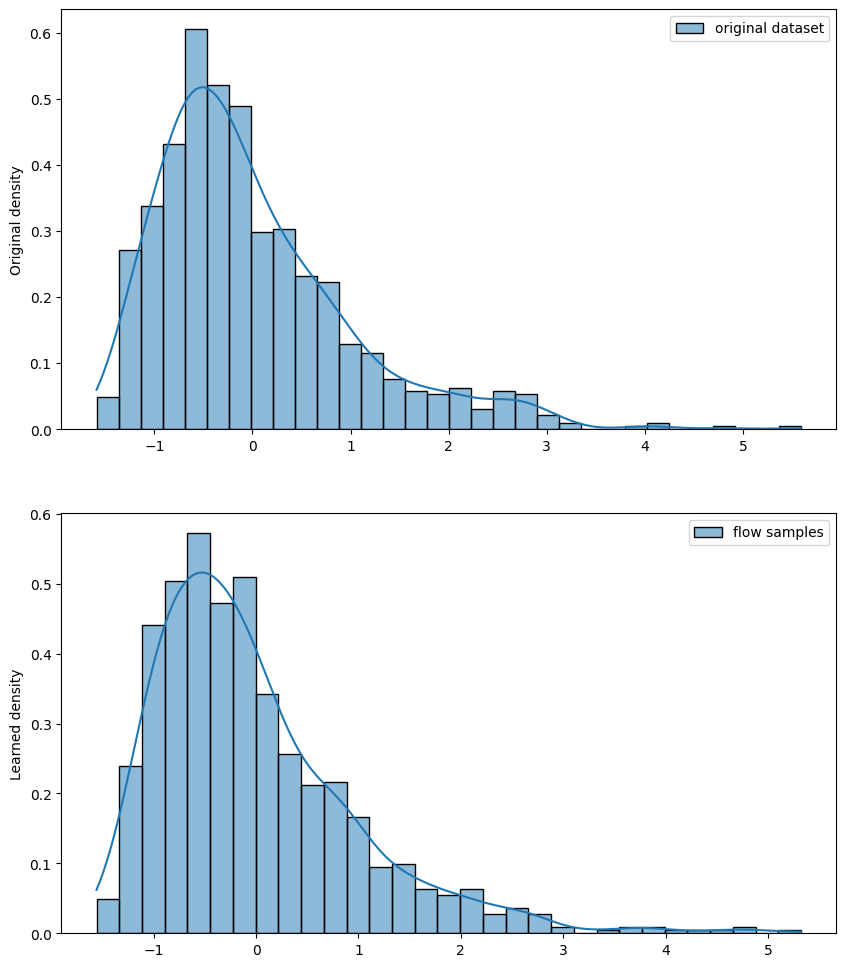

In [110]:
# Plot the base distribution, distribution of the original dataset, and samples from the learned distribution.

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10*1, 6*2))
sns.histplot(data_standardized, kde=True, stat='density', label='original dataset', ax=axes[0])
learned_samples = flow_dist.sample(sample_shape=(n_samples, ))
sns.histplot(learned_samples, kde=True, stat='density', label=r'flow samples', ax=axes[1])
axes[0].set_ylabel('Original density')
axes[1].set_ylabel('Learned density')
axes[0].legend(); axes[1].legend()
plt.show()

(c) To gauge the expressivity of the rational monotonic splines, we will attempt to approximate **a multimodal univariate distribution**.

In [186]:
def complex_univariate_random_variable(n_samples):
    # cheap way to create a more complicated
    # toy univariate random variable    
    X, y = datasets.make_circles(n_samples, noise=0.05, factor=0.5)
    X = StandardScaler().fit_transform(X)
    return X[:, 0].reshape(-1, 1)

Text(0.5, 1.0, 'Complex univariate random variable')

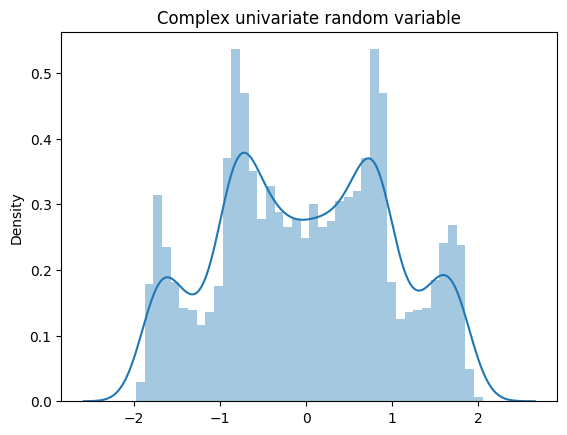

In [187]:
n_samples = 3000
x = complex_univariate_random_variable(n_samples)
sns.distplot(x, hist=True, kde=True, bins=40)
plt.title("Complex univariate random variable")

In [199]:
x = torch.tensor(x)
x.min(), x.max()

(tensor(-1.9769, dtype=torch.float64), tensor(2.0519, dtype=torch.float64))

  (i) Create a simple spline with few (2-5) segments, and approximate the above distribution. How good is the approximation compared to a more expressive spline with 6+ segments?\
\
  (ii) Now create multiple splines with few (2-5) segments, and compose them together to make a more powerful approximation. How well does it learn to approximate this multimodal density?

# 1. a simple spline with few (2-5) segments

In [200]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
spline_transform = T.Spline(1, count_bins=3, order='linear', bound=2)
flow_dist = dist.TransformedDistribution(base_dist,
                                         [spline_transform])

# Implement the training loop after initializing the optimizer and use the loss function provided by `log_prob` method of the TransformedDistribution object. Learn the parameters by optimizing the loss.
steps = 20_000
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-3)

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(x).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 2000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.788043431363808
step: 2000, loss: 1.3816386804179939
step: 4000, loss: 1.3779314396097764
step: 6000, loss: 1.3778632197063319
step: 8000, loss: 1.3777296487778692
step: 10000, loss: 1.3777064624929856
step: 12000, loss: 1.377706341088534
step: 14000, loss: 1.3777064447280503
step: 16000, loss: 1.3777065044227093
step: 18000, loss: 1.377706409428671


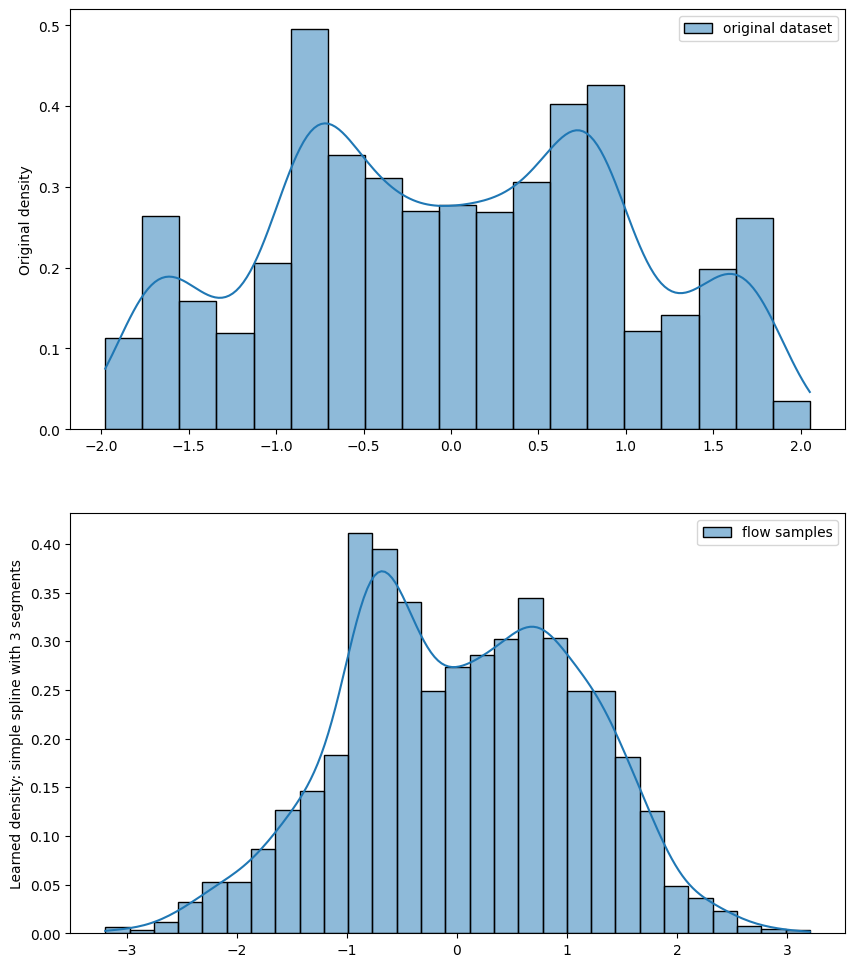

In [201]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10*1, 6*2))
sns.histplot(x, kde=True, stat='density', label='original dataset', ax=axes[0])
learned_samples = flow_dist.sample(sample_shape=(n_samples, ))
sns.histplot(learned_samples, kde=True, stat='density', label=r'flow samples', ax=axes[1])
axes[0].set_ylabel('Original density')
axes[1].set_ylabel('Learned density: simple spline with 3 segments')
axes[0].legend(); axes[1].legend()
plt.show()

# 2. a simple spline 6+ segments

In [202]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
spline_transform = T.Spline(1, count_bins=8, order='linear', bound=2)
flow_dist = dist.TransformedDistribution(base_dist,
                                         [spline_transform])

# Implement the training loop after initializing the optimizer and use the loss function provided by `log_prob` method of the TransformedDistribution object. Learn the parameters by optimizing the loss.
steps = 25_000
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-3)

for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(x).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 2000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.1438927478083216
step: 2000, loss: 1.3687387258968053
step: 4000, loss: 1.3445735838198751
step: 6000, loss: 1.3379281880886023
step: 8000, loss: 1.3359163676881436
step: 10000, loss: 1.3358767907843454
step: 12000, loss: 1.3357997364857324
step: 14000, loss: 1.3357868639609145
step: 16000, loss: 1.3357863561993841
step: 18000, loss: 1.335786802001831
step: 20000, loss: 1.3357878817647484
step: 22000, loss: 1.3357867036216018
step: 24000, loss: 1.3357864035854725


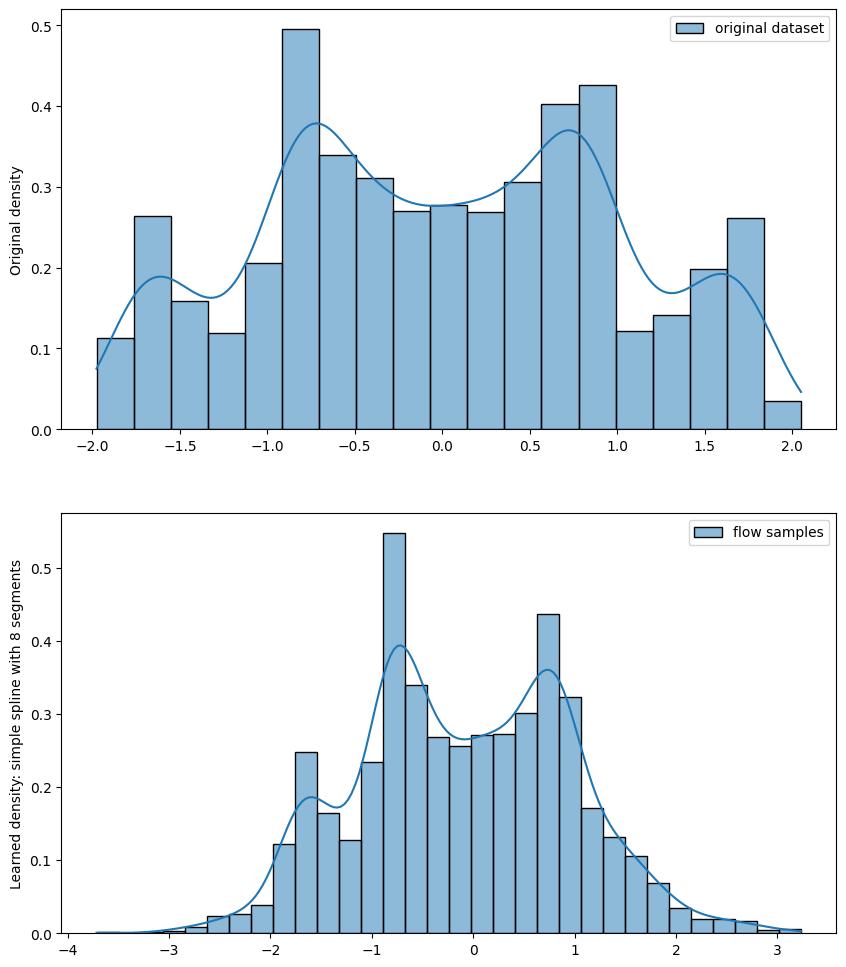

In [203]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10*1, 6*2))
sns.histplot(x, kde=True, stat='density', label='original dataset', ax=axes[0])
learned_samples = flow_dist.sample(sample_shape=(n_samples, ))
sns.histplot(learned_samples, kde=True, stat='density', label=r'flow samples', ax=axes[1])
axes[0].set_ylabel('Original density')
axes[1].set_ylabel('Learned density: simple spline with 8 segments')
axes[0].legend(); axes[1].legend()
plt.show()

In [204]:
torch.randint(low=2, high=5+1, size=(1, )).item()

2

## 3. multiple splines with few (2-5) segments, and compose them together to make a more powerful approximation. 
How well does it learn to approximate this multimodal density?

In [205]:


base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
transforms = [T.Spline(1, count_bins=torch.randint(low=2, high=5+1, size=(1, )).item(), order='linear', bound=2)
              for _ in range(6)]
modules = torch.nn.ModuleList(transforms)
flow_dist = dist.TransformedDistribution(base_dist, transforms)

# Implement the training loop after initializing the optimizer and use the loss function provided by `log_prob` method of the TransformedDistribution object. Learn the parameters by optimizing the loss.
steps = 30_000
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-3)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(x).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 2000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 8.251252075735183
step: 2000, loss: 1.3197914930379575
step: 4000, loss: 1.305493203288172
step: 6000, loss: 1.30236218028491
step: 8000, loss: 1.3019924307408877
step: 10000, loss: 1.301938951669891
step: 12000, loss: 1.301919925082581
step: 14000, loss: 1.3018841949371345
step: 16000, loss: 1.301936177544943
step: 18000, loss: 1.3018695107985514
step: 20000, loss: 1.3018767506119882
step: 22000, loss: 1.3018351501809184
step: 24000, loss: 1.3019542589590094
step: 26000, loss: 1.3019715282862263
step: 28000, loss: 1.3018460397033902


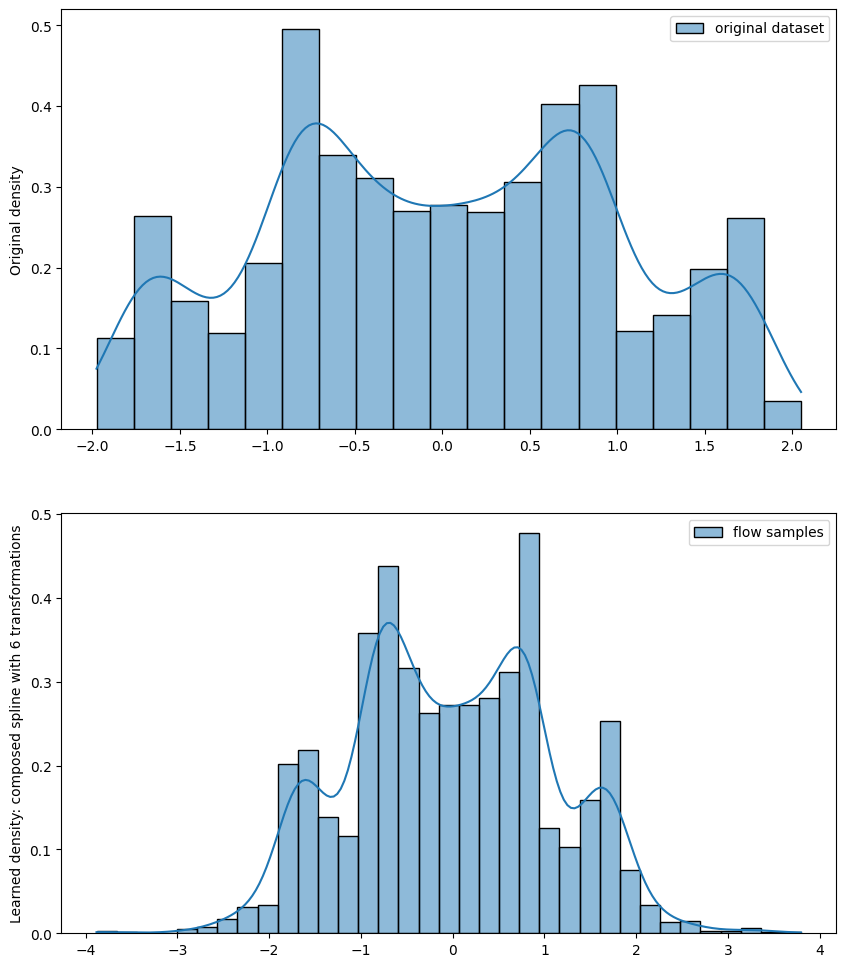

In [206]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10*1, 6*2))
sns.histplot(x, kde=True, stat='density', label='original dataset', ax=axes[0])
learned_samples = flow_dist.sample(sample_shape=(n_samples, ))
sns.histplot(learned_samples, kde=True, stat='density', label=r'flow samples', ax=axes[1])
axes[0].set_ylabel('Original density')
axes[1].set_ylabel('Learned density: composed spline with 6 transformations')
axes[0].legend(); axes[1].legend()
plt.show()

In [182]:
# Train the parameters of the flow. Note that you may have to tweak learning hyperparameters such as number of trainig steps and learning rate.

...


Ellipsis

In [183]:
# Plot samples from the learned flow along with the dataset, and compare the quality of the approximation.

...


Ellipsis

In [184]:
# Write your observations here on the number of segments used vs the number of splines composed together.


## Approximating distributions for multivariate data

The monotonic rational splines used in the previous sections are univariate functions. To approximate multivariate densities, **we need to create expressive _multivariate bijections_**.

In the lecture on normalizing flows, we saw how **_coupling transformations_** can be used to convert **univariate pointwise bijections into more powerful multivariate bijections**.

In this section, you will play around with approximating a density in 2 dimensions. The dataset that will be used is a superposition of 2 hearts, as seen below.

You will first approximate the density by approximating marginals using a spline for each marginal. Then you will use [spline coupling](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling) transforms ([1], Section 2.1) to approximate the 2D distribution.

[1] [Neural Spline Flows (NeurIPS 2019)](https://arxiv.org/pdf/1906.04032.pdf)

In [207]:
def make_hearts(
    n_samples=100, *, shuffle=True, noise=None, random_state=None, factor=0.8, offset=None,
    scale=True
):
    """Make a large heart containing a smaller heart in 2d.

    A simple toy dataset to visualize clustering and classification
    algorithms.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int or tuple of shape (2,), dtype=int, default=100
        If int, it is the total number of points generated.
        For odd numbers, the inner heart will have one point more than the
        outer heart.
        If two-element tuple, number of points in outer heart and inner
        heart.

        .. versionchanged:: 0.23
           Added two-element tuple.

    shuffle : bool, default=True
        Whether to shuffle the samples.

    noise : float, default=None
        Standard deviation of Gaussian noise added to the data.

    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset shuffling and noise.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.

    factor : float, default=.8
        Scale factor between inner and outer heart in the range `(0, 1)`.

    Returns
    -------
    X : ndarray of shape (n_samples, 2)
        The generated samples.

    y : ndarray of shape (n_samples,)
        The integer labels (0 or 1) for class membership of each sample.
    """
    
    import numbers
    from sklearn.utils import shuffle as util_shuffle
    from sklearn.utils import check_random_state

    if factor >= 1 or factor < 0:
        raise ValueError("'factor' has to be between 0 and 1.")

    if isinstance(n_samples, numbers.Integral):
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
    else:
        try:
            n_samples_out, n_samples_in = n_samples
        except ValueError as e:
            raise ValueError(
                "`n_samples` can be either an int or a two-element tuple."
            ) from e

    generator = check_random_state(random_state)
    # so as not to have the first point = last point, we set endpoint=False
    linspace_out = np.linspace(0, 2 * np.pi, n_samples_out, endpoint=False)
    linspace_in = np.linspace(0, 2 * np.pi, n_samples_in, endpoint=False)
    
    def heart(t):
        return (16 * np.sin(t) ** 3,
                13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t))
    
    outer_heart_x, outer_heart_y = heart(linspace_in)
    inner_heart_x, inner_heart_y = heart(linspace_out)
    if offset is not None:
        inner_heart_x += offset[0]
        inner_heart_y += offset[1]
    inner_heart_x *= factor
    inner_heart_y *= factor

    X = np.vstack(
        [np.append(outer_heart_x, inner_heart_x), np.append(outer_heart_y, inner_heart_y)]
    ).T
    y = np.hstack(
        [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
    )
    if shuffle:
        X, y = util_shuffle(X, y, random_state=generator)

    if noise is not None:
        X += generator.normal(scale=noise, size=X.shape)
        
    if scale:
        X = StandardScaler().fit_transform(X)

    return X, y

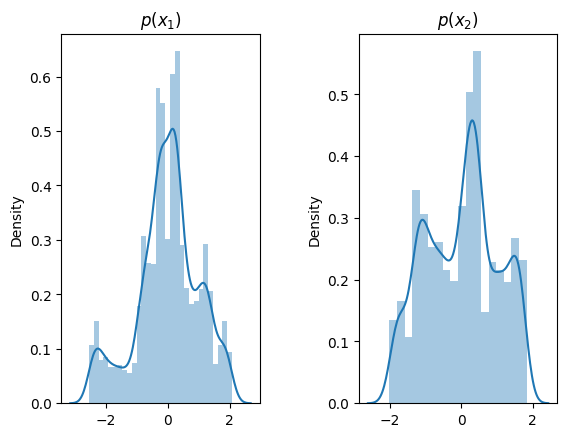

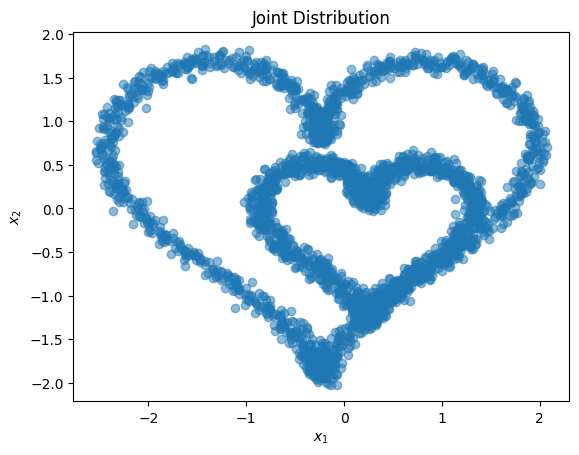

In [208]:
# creating the hearts dataset and visualizing marginals and joint density


X, _ = make_hearts(n_samples, factor=0.5, noise=0.5, offset=[7, -7])

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], label='data')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], label='data')
plt.title(r'$p(x_2)$')
plt.subplots_adjust(wspace=0.5)
plt.show()


plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.show()

In [210]:
X.min(), X.max()

(-2.5378254019516437, 2.0717337381209573)

4. Use a 2D `Spline` to learn the multivariate transformation. Plot the marginals and plot the joint distribution of the learned distribution, and compare against the data.

In [221]:
# Create the learnable distribution with 2D Spline

dim=2
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform = T.Spline(dim, count_bins=16, order='linear', bound=3)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

# Implement the training loop after initializing the optimizer and use the loss function
# provided by `log_prob` method of the TransformedDistribution object.
# Learn the parameters by optimizing the loss.

x = torch.tensor(X)
flow_dist.log_prob(x).shape

torch.Size([3000, 2])

In [222]:
steps = 10_000
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-3)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(x).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 1000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.4157061638480934
step: 1000, loss: 1.509552844551627
step: 2000, loss: 1.3084453405394931
step: 3000, loss: 1.2756182613551645
step: 4000, loss: 1.2662617782536414
step: 5000, loss: 1.2612836829694216
step: 6000, loss: 1.2591726195057653
step: 7000, loss: 1.257895803298536
step: 8000, loss: 1.257181530362721
step: 9000, loss: 1.256782123300611


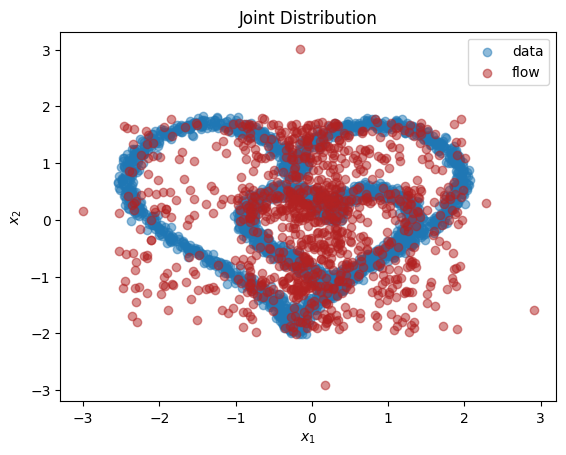

In [227]:
# Plot the marginals and joint density of the learned distribution and compare against the true data distribution.

X_flow = flow_dist.sample(torch.Size([1000, ]))#.detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

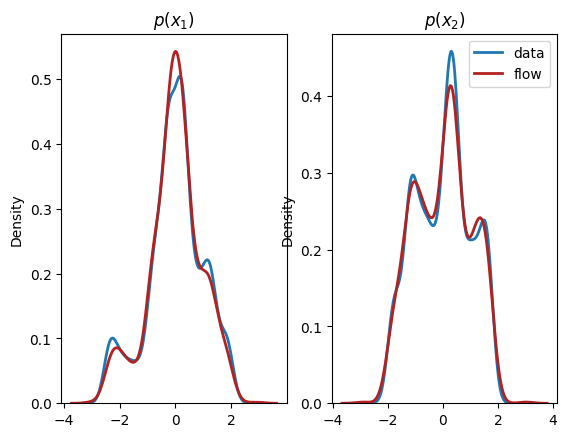

In [228]:
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.legend()
plt.title(r'$p(x_2)$')
plt.show()

Question: How well does the learned distribution approximate the marginals? How well does it approximate the joint density? Justify your observations.

---

- the learned density for marginals look pretty good!
- the joint density is not learned properly at all, as the heart shape is not formed by sampled points.

Reason: Spline transforms work elementwise, so correlation between dimensions is not captured by the flow density. 

In [230]:
# event_dim property of a transform indicates how many dependent dimensions 
# there are in the output of a transform.
spline_transform.event_dim

0

5. Use [`SplineCoupling`](https://docs.pyro.ai/en/stable/distributions.html#splinecoupling) to learn the complex multivariate transformation. Plot and inspect the marginals and joint density.


In [231]:
# Create learnable distribution
# create a bivariate flow with a single spline coupling layer as follows
dim=2
base_dist = dist.Normal(torch.zeros(dim), torch.ones(dim))
spline_transform = T.spline_coupling(dim, count_bins=16, bound=3)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])


In [234]:
list(spline_transform.children())

[Spline(),
 ConditionalSpline(
   (nn): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=1, out_features=20, bias=True)
       (1): Linear(in_features=20, out_features=20, bias=True)
       (2): Linear(in_features=20, out_features=63, bias=True)
     )
     (f): ReLU()
   )
 )]

why are there 63 output parameters?
- note that there are 16 quadratic $g_i/h_i$spline pieces
- so each piece has 3 parameters => 16*3 = 48 parameters
- then the location of the splines $b_i$-s are also learned except the starting ($-B$) and end points ($B$)
- so total = $48 + (16-1)$ = $63$

In [246]:
list(spline_transform.children())[1].nn.layers[0].weight.dtype

torch.float32

In [247]:
# flow_dist.sample(sample_shape=(2,))
x = torch.tensor(x, dtype=torch.float32)
flow_dist.log_prob(x).shape

torch.Size([3000])

In [249]:
# Learn the parameters of the coupling splie flow
steps = 10_000
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-3)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(x).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    if step % 1000 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 1.3878014087677002
step: 1000, loss: 1.3784962892532349
step: 2000, loss: 1.3820489645004272
step: 3000, loss: 1.384028434753418
step: 4000, loss: 1.3686673641204834
step: 5000, loss: 1.3699021339416504
step: 6000, loss: 1.35932195186615
step: 7000, loss: 1.356550931930542
step: 8000, loss: 1.3576959371566772
step: 9000, loss: 1.3540953397750854


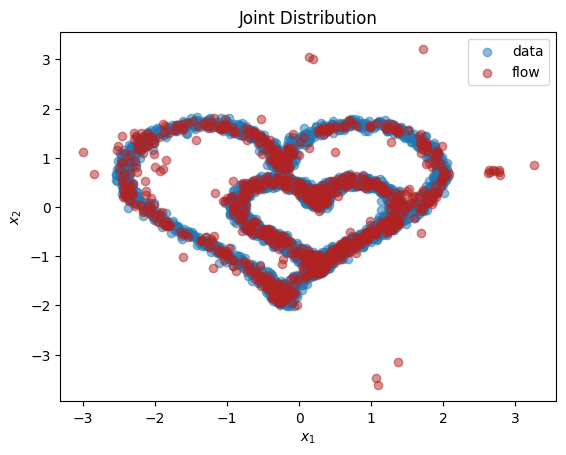

In [250]:
# Plot the marginals and joint of the learned distribution against the true data distribution.
X_flow = flow_dist.sample(torch.Size([1000, ]))#.detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()


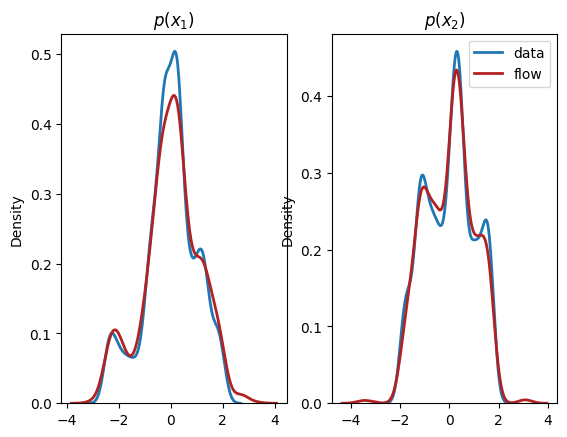

In [251]:
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.legend()
plt.title(r'$p(x_2)$')
plt.show()

Question: What is the quality of the marginal and joint densities with the coupling transformation?

- now the joint density also looks good!

In [252]:
from pyro.nn import DenseNN
input_dim = 10
split_dim = 6
count_bins = 8
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
param_dims = [(input_dim - split_dim) * count_bins,
              (input_dim - split_dim) * count_bins,
              (input_dim - split_dim) * (count_bins - 1),
              (input_dim - split_dim) * count_bins]
hypernet = DenseNN(split_dim, [10*input_dim], param_dims)
# transform = SplineCoupling(input_dim, split_dim, hypernet)
# pyro.module("my_transform", transform)  
# flow_dist = dist.TransformedDistribution(base_dist, [transform])
# flow_dist.sample()  

In [259]:
hypernet

DenseNN(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=124, bias=True)
  )
  (f): ReLU()
)

In [258]:
ms = list(hypernet.modules())
ms

[DenseNN(
   (layers): ModuleList(
     (0): Linear(in_features=6, out_features=100, bias=True)
     (1): Linear(in_features=100, out_features=124, bias=True)
   )
   (f): ReLU()
 ),
 ModuleList(
   (0): Linear(in_features=6, out_features=100, bias=True)
   (1): Linear(in_features=100, out_features=124, bias=True)
 ),
 Linear(in_features=6, out_features=100, bias=True),
 Linear(in_features=100, out_features=124, bias=True),
 ReLU()]

## Miscellaneous helper code

torch.Size([1000, 1]) torch.Size([1000, 1])


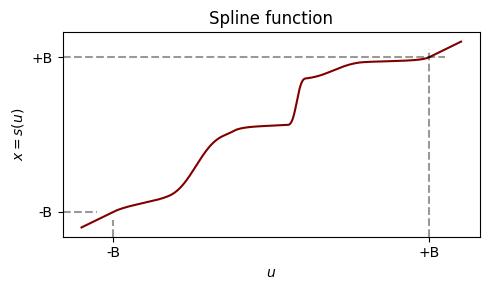

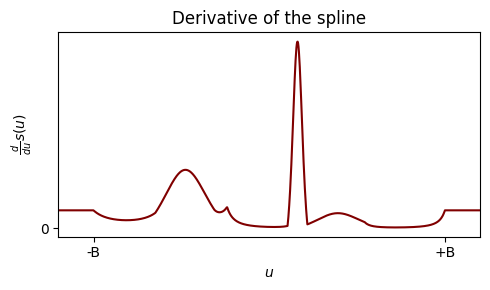

In [55]:
def visualize_spline(spline_: T.Spline, dim=0):
    '''
    Helper function for plotting the spline function with its derivatives.
    Args:
        spline_: `Spline` object
        dim: dimension of the spline to visualize, for multivariate spline
    '''
    with torch.no_grad():
        D = spline_.input_dim
        B = spline.bound
        u = torch.from_numpy(np.linspace(-1.2*B, 1.2*B, 1000))
        x, logdet = spline_.spline_op(u.unsqueeze(1).repeat(1, D))
        print(x.shape, logdet.shape)
        det = logdet.exp()
        fig = plt.figure(figsize=(5,3), dpi=100)

        plt.plot(u, x[:,dim].cpu(), color='maroon')
        plt.xticks([-1*B, 1*B], [r'-B', r'+B'])
        plt.yticks([-1*B, 1*B], [r'-B', r'+B'])
        # plt.xlim((-1.2*B, 1.2*B))
        # plt.ylim((-1.2*B, 1.2*B))
        plt.axvline(x=-1*B, ymin=0, ymax=0.2/2.4, color='k', alpha=0.4, linestyle='--')
        plt.axhline(y=-1*B, xmin=0, xmax=0.2/2.4, color='k', alpha=0.4, linestyle='--')
        plt.axvline(x=1*B, ymax=2.2/2.4, ymin=0, color='k', alpha=0.4, linestyle='--')
        plt.axhline(y=1*B, xmax=2.2/2.4, xmin=0, color='k', alpha=0.4, linestyle='--')
        plt.xlabel(r'$u$')
        plt.ylabel(r'$x=s(u)$')
        plt.title(r'Spline function')
        fig.tight_layout()

        plt.show()

        fig = plt.figure(figsize=(5,3), dpi=100)

        plt.plot(u, det[:,dim].cpu(), color='maroon')
        plt.xticks([-1*B, 1*B], [r'-B', r'+B'])
        plt.yticks([0], [r'0'])
        plt.xlim((-1.2*B, 1.2*B))
        plt.xlabel(r'$u$')
        plt.ylabel(r'$\frac{d}{du}s(u)$')
        plt.title(r'Derivative of the spline')
        fig.tight_layout()
        plt.show()


spline = T.Spline(1, count_bins=7, bound=2.0, order='quadratic')
visualize_spline(spline)



torch.Size([1000, 1]) torch.Size([1000, 1])


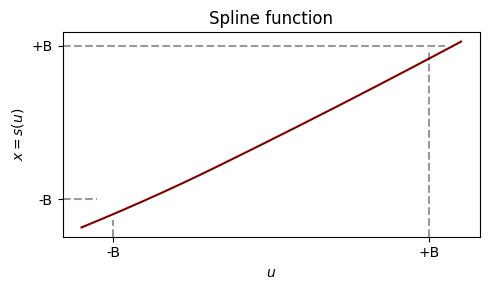

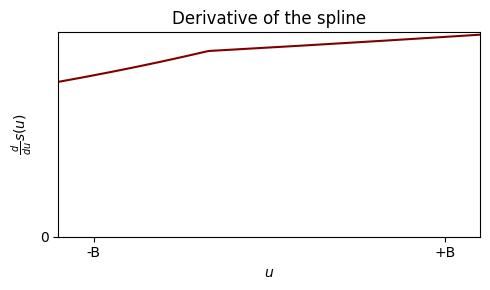

In [89]:
spline_transform = T.Spline(1, count_bins=2, order='linear', bound=6)
visualize_spline(spline_transform)